In [103]:
import math
import os
import pickle
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

In [104]:
!conda install --yes --prefix {sys.prefix} pytorch torchvision torchaudio -c pytorch

Solving environment: done

# All requested packages already installed.



In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [111]:
class LSTM(nn.Module):
    def __init__(self, D_in, H, D_out, L):
        super(LSTM, self).__init__()
        self.input_dim = D_in
        self.hidden_dim = H
        self.output_dim = D_out
        self.layer_num = L 
        
        self.lstm = nn.LSTM(input_size = D_in, 
                            hidden_size = H, 
                            num_layers = L, 
                            batch_first = True)
        self.linear1 = nn.Linear(H, D_out)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, hidden):
        lstm_pred, h_pred = self.lstm(x, hidden)
        lstm_pred = lstm_pred.contiguous().view(-1, self.hidden_dim)
        
        y_pred = self.linear1(lstm_pred)
        y_pred = self.sigmoid(y_pred)
        
        return y_pred, h_pred
    
    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.layer_num, 1, self.hidden_dim).zero_().to(torch.device("cpu")),
                      weight.new(self.layer_num, 1, self.hidden_dim).zero_().to(torch.device("cpu")))
        return hidden

## Load Data

In [124]:
PATH_TO_SAVED_MODELS = os.getcwd() + "/Results/"
PATH_TO_SAVED_DATA = os.getcwd() + "/Processed Data/"

MLP_models = pickle.load(open(PATH_TO_SAVED_MODELS + "MLP_Models.p", "rb"))
LSTM_models = pickle.load(open(PATH_TO_SAVED_MODELS + "LSTM_Models.p", "rb"))

CRF_recall = pickle.load(open(PATH_TO_SAVED_MODELS + "CRF_recall.p", "rb"))
CRF_accuracy = pickle.load(open(PATH_TO_SAVED_MODELS + "CRF_accuracy.p", "rb"))
CRF_auc = pickle.load(open(PATH_TO_SAVED_MODELS + "CRF_auc.p", "rb"))

test_data = pickle.load(open(PATH_TO_SAVED_DATA + "test_data.p", "rb"))
test_labels = pickle.load(open(PATH_TO_SAVED_DATA + "test_labels.p", "rb"))

# Convert data and labels to tensors
dtype = torch.FloatTensor
test_data = Variable(torch.from_numpy(test_data).type(dtype), requires_grad=False)
test_labels = Variable(torch.from_numpy(test_labels).type(dtype), requires_grad=False)

## Get the results from each set of models

In [113]:
def test(model, test_data, test_labels, model_type):
    """model_type 0: CRF 1: MLP 2: LSTM"""
    if model_type == 0:
        y_pred = model.forward(test_data)
    elif model_type == 1:
        y_pred = model.forward(test_data)
    else:
        hidden = model.init_hidden()
        y_pred, h_pred = model.forward(test_data, hidden)
        
    y_pred = np.asarray(y_pred.detach().numpy())
    y_score = y_pred
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(int)

    y_true = np.asarray(test_labels.detach().numpy())
    
    return y_true, y_pred, y_score


def generate_results(models, test_data, test_labels, model_type):
    confusion_matrix = []
    recall = []
    f1 = []
    accuracy = []
    auc = []
    
    # LSTM data format
    if model_type == 2:
        test_data = test_data.unsqueeze(dim=0)
    
    for model in models:
        y_true, y_pred, y_score = test(model, test_data, test_labels, model_type)
        
        confusion_matrix.append(metrics.confusion_matrix(y_true, y_pred, labels=[0,1]))
        recall.append(metrics.recall_score(y_true, y_pred))
        f1.append(metrics.f1_score(y_true, y_pred))
        accuracy.append(metrics.accuracy_score(y_true, y_pred))
        auc.append(metrics.roc_auc_score(y_true, y_score))
    
    return confusion_matrix, recall, f1, accuracy, auc        

In [115]:
CRF_recall_mean = sum(CRF_recall) / len(CRF_recall)
#CRF_f1_mean = sum(CRF_f1) / len(CRF_f1)
CRF_accuracy_mean = sum(CRF_accuracy) / len(CRF_accuracy)
CRF_auc_mean = sum(CRF_auc) / len(CRF_auc)

CRF_recall_std = np.std(np.asarray(CRF_recall))
#CRF_f1_std = np.std(np.asarray(CRF_f1))
CRF_accuracy_std = np.std(np.asarray(CRF_accuracy))
CRF_auc_std = np.std(np.asarray(CRF_auc))

sem_denom = math.sqrt(len(CRF_recall))

CRF_recall_sem = CRF_recall_std / sem_denom
#CRF_f1_sem = CRF_f1_std / sem_denom
CRF_accuracy_sem = CRF_accuracy_std / sem_denom
CRF_auc_sem = CRF_auc_std / sem_denom

# Get MLP Results
MLP_conf_mat, MLP_recall, MLP_f1, MLP_accuracy, MLP_auc = generate_results(MLP_models, 
                                                                           test_data, 
                                                                           test_labels, 
                                                                           1)
MLP_recall_mean = sum(MLP_recall) / len(MLP_recall)
MLP_f1_mean = sum(MLP_f1) / len(MLP_f1)
MLP_accuracy_mean = sum(MLP_accuracy) / len(MLP_accuracy)
MLP_auc_mean = sum(MLP_auc) / len(MLP_auc)

MLP_recall_std = np.std(np.asarray(MLP_recall))
MLP_f1_std = np.std(np.asarray(MLP_f1))
MLP_accuracy_std = np.std(np.asarray(MLP_accuracy))
MLP_auc_std = np.std(np.asarray(MLP_auc))

sem_denom = math.sqrt(len(MLP_models))

MLP_recall_sem = MLP_recall_std / sem_denom
MLP_f1_sem = MLP_f1_std / sem_denom
MLP_accuracy_sem = MLP_accuracy_std / sem_denom
MLP_auc_sem = MLP_auc_std / sem_denom

# Get LSTM Results
LSTM_conf_mat, LSTM_recall, LSTM_f1, LSTM_accuracy, LSTM_auc = generate_results(LSTM_models, 
                                                                                test_data, 
                                                                                test_labels, 
                                                                                2)

LSTM_recall_mean = sum(LSTM_recall) / len(LSTM_recall)
LSTM_f1_mean = sum(LSTM_f1) / len(LSTM_f1)
LSTM_accuracy_mean = sum(LSTM_accuracy) / len(LSTM_accuracy)
LSTM_auc_mean = sum(LSTM_auc) / len(LSTM_auc)

LSTM_recall_std = np.std(np.asarray(LSTM_recall))
LSTM_f1_std = np.std(np.asarray(LSTM_f1))
LSTM_accuracy_std = np.std(np.asarray(LSTM_accuracy))
LSTM_auc_std = np.std(np.asarray(LSTM_auc))

sem_denom = math.sqrt(len(LSTM_models))

LSTM_recall_sem = LSTM_recall_std / sem_denom
LSTM_f1_sem = LSTM_f1_std / sem_denom
LSTM_accuracy_sem = LSTM_accuracy_std / sem_denom
LSTM_auc_sem = LSTM_auc_std / sem_denom

# Graph Results

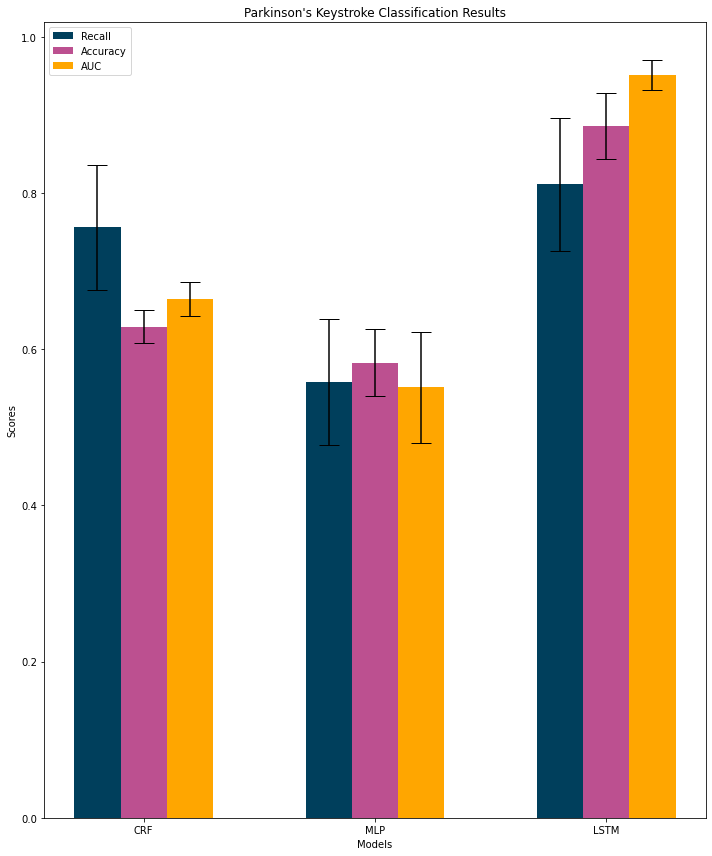

In [118]:
labels = ["CRF", 'MLP', 'LSTM']
recall_means = [CRF_recall_mean, MLP_recall_mean, LSTM_recall_mean]
#f1_means = , MLP_f1_mean, LSTM_f1_mean]
accuracy_means = [CRF_accuracy_mean, MLP_accuracy_mean, LSTM_accuracy_mean]
auc_means = [CRF_auc_mean, MLP_auc_mean, LSTM_auc_mean]

recall_error = [CRF_recall_sem, MLP_recall_sem, LSTM_recall_sem]
#f1_error = [0.05, MLP_f1_sem, LSTM_f1_sem]
accuracy_error = [CRF_accuracy_sem, MLP_accuracy_sem, LSTM_accuracy_sem]
auc_error = [CRF_auc_sem, MLP_auc_sem, LSTM_auc_sem]

# Round values
recall_means = [round(i, 3) for i in recall_means]
#f1_means = [round(i, 3) for i in f1_means]
accuracy_means = [round(i, 3) for i in accuracy_means]
auc_means = [round(i, 3) for i in auc_means]

recall_error = [round(i, 3) for i in recall_error]
#f1_error = [round(i, 3) for i in f1_error]
accuracy_error = [round(i, 3) for i in accuracy_error]
auc_error = [round(i, 3) for i in auc_error]


x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots(figsize=(10,12))
rects1 = ax.bar(x - width, recall_means, width, yerr=recall_error, capsize=10, label='Recall', color="#003f5c")
#rects2 = ax.bar(x , f1_means, width, yerr=f1_error, capsize=10, label='F1', color="#7a5195")
rects3 = ax.bar(x, accuracy_means, width, yerr=accuracy_error, capsize=10, label="Accuracy", color="#bc5090")
rects4 = ax.bar(x + width, auc_means, width, yerr=auc_error, capsize=10, label="AUC", color="#ffa600")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Scores")
ax.set_xlabel("Models")
ax.set_title("Parkinson's Keystroke Classification Results")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)
#autolabel(rects4)

fig.tight_layout()

plt.show()

## Tables

### All Test Input

In [130]:
# Recall
all_recall = np.append([CRF_recall], [MLP_recall], axis=0)
all_recall = np.append(all_recall, [LSTM_recall], axis=0)
all_recall = pd.DataFrame(all_recall.transpose(), columns=["CRF", "MLP", "LSTM"])
all_recall = all_recall.round(3)
print("ALL RECALL")
print(all_recall)
print("")

# Accuracy
all_accuracy = np.append([CRF_accuracy], [MLP_accuracy], axis=0)
all_accuracy = np.append(all_accuracy, [LSTM_accuracy], axis=0)
all_accuracy = pd.DataFrame(all_accuracy.transpose(), columns=["CRF", "MLP", "LSTM"])
all_accuracy = all_accuracy.round(3)
print("ALL ACCURACY")
print(all_accuracy)
print("")

# AUC
all_auc = np.append([MLP_auc], [MLP_auc], axis=0)
all_auc = np.append(all_auc, [LSTM_auc], axis=0)
all_auc = pd.DataFrame(all_auc.transpose(), columns=["CRF", "MLP", "LSTM"])
all_auc = all_auc.round(3)
print("ALL AUC")
print(all_auc)
print("")

ALL RECALL
      CRF    MLP   LSTM
0   1.000  0.756  0.952
1   0.780  0.477  0.203
2   0.916  0.664  0.908
3   0.916  0.932  0.985
4   1.000  0.220  0.969
5   0.000  0.509  0.997
6   0.780  0.218  0.963
7   0.780  0.218  0.072
8   0.000  1.000  0.199
9   1.000  0.219  0.996
10  1.000  0.895  0.971
11  0.780  0.220  0.964
12  0.780  1.000  0.992
13  0.837  0.220  0.995
14  0.780  0.817  0.996

ALL ACCURACY
      CRF    MLP   LSTM
0   0.506  0.781  0.963
1   0.665  0.587  0.575
2   0.725  0.754  0.954
3   0.725  0.792  0.984
4   0.502  0.417  0.953
5   0.500  0.628  0.991
6   0.664  0.425  0.946
7   0.664  0.427  0.536
8   0.500  0.500  0.583
9   0.715  0.418  0.981
10  0.591  0.875  0.916
11  0.664  0.421  0.981
12  0.664  0.501  0.946
13  0.686  0.415  0.988
14  0.661  0.800  0.998

ALL AUC
      CRF    MLP   LSTM
0   0.851  0.851  0.968
1   0.631  0.631  0.943
2   0.839  0.839  0.997
3   0.888  0.888  0.991
4   0.335  0.335  0.952
5   0.728  0.728  0.992
6   0.288  0.288  0.938
7   0.

### Averages with Error

In [123]:
# Recall
print("RECALL")
print("CRF")
print(CRF_recall_mean)
print(CRF_recall_sem)

print("MLP")
print(MLP_recall_mean)
print(MLP_recall_sem)

print("LSTM")
print(LSTM_recall_mean)
print(LSTM_recall_sem)

# Accuracy
print("ACCURACY")
print("CRF")
print(CRF_accuracy_mean)
print(CRF_accuracy_sem)

print("MLP")
print(MLP_accuracy_mean)
print(MLP_accuracy_sem)

print("LSTM")
print(LSTM_accuracy_mean)
print(LSTM_accuracy_sem)

# AUC
print("AUC")
print("CRF")
print(CRF_auc_mean)
print(CRF_auc_sem)

print("MLP")
print(MLP_auc_mean)
print(MLP_auc_sem)

print("LSTM")
print(LSTM_auc_mean)
print(LSTM_auc_sem)

RECALL
CRF
0.7564753004005342
0.0800636584567887
MLP
0.557543391188251
0.08052541568342067
LSTM
0.8107699154428128
0.08476244888740596
ACCURACY
CRF
0.6286159323542501
0.021300318193860447
MLP
0.5826435246995996
0.0431677150184249
LSTM
0.8863818424566088
0.041939152204293506
AUC
CRF
0.6635398748546497
0.02172730566009324
MLP
0.5510802416870321
0.07142405052581698
LSTM
0.9507950966219312
0.019277344268850072
